# Assignment 4

## Instructions
<ul>
    <li> Ensure that this assignment is your own work. PLagiarism will not be tolerated </li>
    <li> Ensure that all cells of this notebook run without error when run in order </li>
    <li> Follow the late day policy. Submit assignments on time </li>
    <li> Provide clear explanation for the algorithms you implement </li>
</ul>
Date released: 26/10/2020 

Due date: 01/11/2020 

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

---
## 4.1
### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [3]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

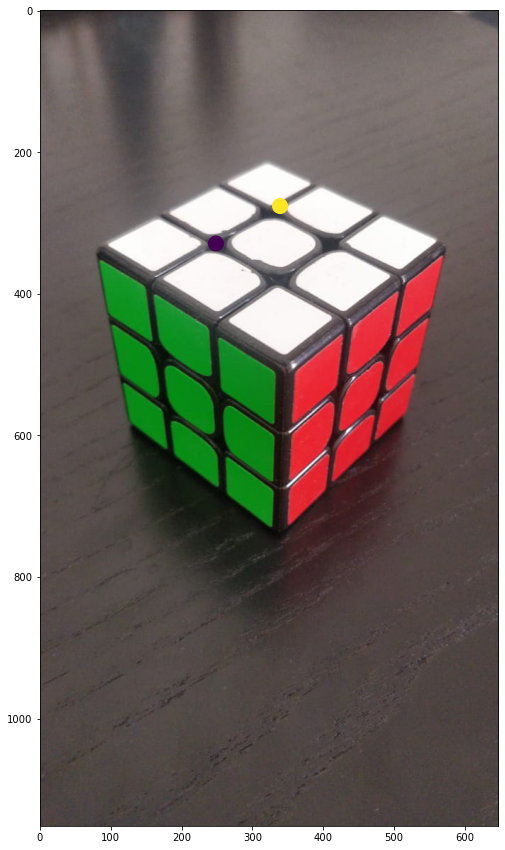

In [4]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [3]:
#We'll rename image_points to x to match textbook convention
x = image_points
# X represents the 3D world points
X = []
#Add your points here
#Add them as 3D points only
X.append([0,0.04,0.04])
X.append([0,0,0.04])
X.append([0.04,0,0.04])
X.append([0,0.04,0])
X.append([0,0,0])
X.append([0.04,0,0])
print(x)
X = np.array(X)

[[100.57523556 339.30127642]
 [345.14519638 499.32853473]
 [559.52133487 334.77220307]
 [340.61612303 724.27251104]
 [129.25936677 583.87123724]]


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [4]:
#Helper functions
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

x,X = hom_coords(x,X)



ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 6 and the array at index 1 has size 5

#### Explanation

Edit this cell and explain the DLT algorithm:

# DLT Explanation

## Finding the Matrix P
- DLT is used to transform any object point X to image point x by: 

$$x_{3x1} =  P_{3x4}X_{4x1}$$

- Here the P matrix is the camera parameter matrix that includes both intrinsic and extrinsic camera parameters.It has 12 parameters , but we only need to find the 11 parameters keeping the last term as 1 for retaining homogenity.

$$A^{T} = \left[\begin{array}{r}p_{11}&p_{12}&p_{13}&p_{14}\end{array}\right]$$
$$B^{T} = \left[\begin{array}{r}p_{21}&p_{22}&p_{23}&p_{24}\end{array}\right]$$
$$C^{T} = \left[\begin{array}{r}p_{31}&p_{32}&p_{33}&p_{34}\end{array}\right]$$

$$\therefore P = \left[\begin{array}{rrr}A^{T}\\B^{T}\\C^{T}\end{array}\right]$$

- Each pair of correspondence gives two equations and in total we need minimum 6 such correspondences to solve for P. thus for "I" correspondences the matrix of equations will be as follows

$$S_{2Ix12} = \left[\begin{array}{rrrrrrrr}a_{x_{1}}^{T}\\a_{y_{1}}^{T}\\a_{x_{2}}^{T}\\a_{y_{2}}^{T}\\.\\.\\.\\a_{x_{I}}^{T}\\a_{y_{I}}^{T}\end{array}\right]$$

And $$S*P = 0 $$

- P belongs to $nullSpace(S)$, which is difficult to find directly.
- So we use SVD method for a good estimate 

 $$S = UDV^{T}$$

- A good estimate for $nullSpace(S)$ would be taking the eigen vector in $V$ corresponding to smallest eigen value, which is the last column of $V$ as our vectorised matrix $p$.


- Then On rearranging  $P_{12x1}$ to $P_{3x4}$ and dividing the matrix by "$P_{34}$". We get P matrix


In [8]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
from scipy.linalg import svd
def DLT(x,X):
    """
    your code here
    """
    A = np.zeros((12,12))
    P = np.random.randn(3,4)
    for i in range(6):
        A[2*i][:4] = X[i]
        A[2*i][8:] = -x[i][0]*X[i]
        
        A[2*i +1][4:8] = X[i]
        A[2*i +1][8:] = -x[i][1]*X[i]
    u,d,vt = svd(A)
    l = vt[11]
    for i in range(3):
        P[i]=l[4*i:4*(i+1)]
    return P

P = DLT(x,X)


In [9]:
print(P)

[[ 5.57515759e-01 -3.85747941e-01 -1.29992070e-01  2.65431747e-02]
 [-1.18246332e-01 -1.65717334e-01 -6.91345094e-01  5.80461374e-02]
 [ 3.75879657e-04  2.20178747e-04 -4.55697685e-04  7.94744888e-05]]


## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [33]:
#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    """
    n = points.shape[0]
    size = (n,1)
    ones = np.ones(size)
    points = np.concatenate(
        (points,ones),
        axis = 1)    
    err = (np.square(points - x)).mean(axis=None)
    print("Predicted :\n\n",points,"\n\n")
    
    print("Original :\n\n",x,"\n\n")
    
    print("Error :",Er)
    #to err is to human
    return err
Er = get_err(x,X,P)


Predicted :

 [[ 84.41483614 339.22019407   1.        ]
 [348.48462374 496.2290626    1.        ]
 [572.14356145 336.41696027   1.        ]
 [125.88412713 582.4251206    1.        ]
 [333.98358465 730.37446714   1.        ]
 [516.81274936 564.13572575   1.        ]] 


Original :

 [[ 83.96863328 339.30127642   1.        ]
 [349.67426973 496.3091525    1.        ]
 [571.5988638  336.28189419   1.        ]
 [126.23998454 582.36154612   1.        ]
 [333.06766745 730.31127551   1.        ]
 [517.24998362 564.24525273   1.        ]] 


Error : 0.17327918580003154


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [20]:
def ret_RKT(P):
    """
    """
    h_inf = P[:,0:3]
    hi = np.linalg.inv(H_inf)    
    q,r= np.linalg.qr(hi)
    h  = P[:,3]
    T  = -hi@h
    R  = q.T
    K_t = np.linalg.inv(r)
    K  = K_t/K_t[2][2]
    return R, K , T 

In [21]:
R,K,T=ret_RKT(P)

print("R : \n\n",R,"\n")
print("K : \n\n",K,"\n")
print("T : \n\n",T,"\n")

R : 

 [[-0.58487189  0.80576403 -0.09310851]
 [-0.54992922 -0.47829095 -0.68470111]
 [-0.59624048 -0.34925934  0.72285212]] 

K : 

 [[ 991.08137191   52.48714198  462.63474829]
 [  -0.         -979.75428846  589.06908777]
 [   0.            0.            1.        ]] 

T : 

 [-0.05615925 -0.04774379  0.10501085] 



Reproject the world points with P matrix you have obtained via DLT:

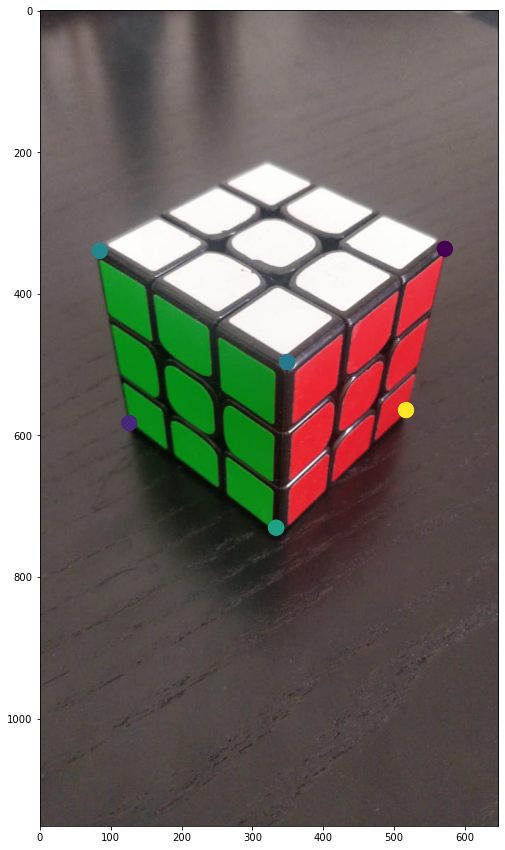

In [43]:

re_proj = get_points(P, X)
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1],c=colors, s=area)

plt.scatter(re_proj[:,0], re_proj[:,1],c=colors,  s=area)

plt.show()
#code to plot these on the image

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. Familiarize yourself with the different parameters for this method.

In [30]:
#Code for zhangs here
import cv2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# preparing object points
objp = np.zeros((8*6,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for i in range(56,71):
    fname ="./Images/Zhangs/IMG_54"+str(i)+".JPG"
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6),None)
    
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (8,6), corners2,ret)
#        print("The corners in the image " + fname +" are ")
#        print(corners2)
#        plt.imshow(img)
#        plt.show()
#        cv2.waitKey(100)
#cv2.destroyAllWindows();
ret, K, dist, rvec, t = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print(K)
 

[[1.36415095e+04 0.00000000e+00 3.31635924e+03]
 [0.00000000e+00 1.36632518e+04 1.50037425e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


---
## 4.2
### Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points have been provided to you. The images are in q2 folder.

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

In [5]:
data_file = "q2/data.txt"

with open(data_file, 'r') as f:
    A = f.readlines()
    
img_points1 = A[2:12]
img_points1 = [i.strip()[:-1] for i in img_points1]
img_points1[0] = img_points1[0][1:]
img_points2 = A[15:25]
img_points2 = [i.strip()[:-1] for i in img_points2]
img_points2[0] = img_points2[0][1:]

F_mat = A[28:31]
F_mat = [i.strip()[:-1] for i in F_mat]
F_mat[0] = F_mat[0][1:]

img_1 = []
img_2 = []
F_MAT = []

for i in img_points1:
    img_1.append(np.fromstring(i[1:-1], sep=' '))
    
for i in img_points2:
    img_2.append(np.fromstring(i[1:-1], sep=' '))
    
for i in F_mat:
    F_MAT.append(np.fromstring(i[1:-1], sep=' '))

img_1 = np.array(img_1)
img_2 = np.array(img_2)
F_mat = np.array(F_MAT)

Provide a clear explanation on your approach for both this task and the next:

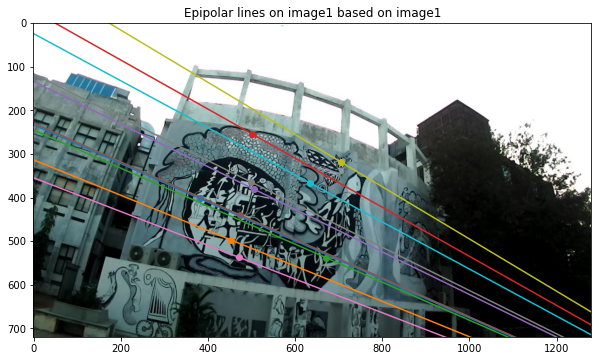

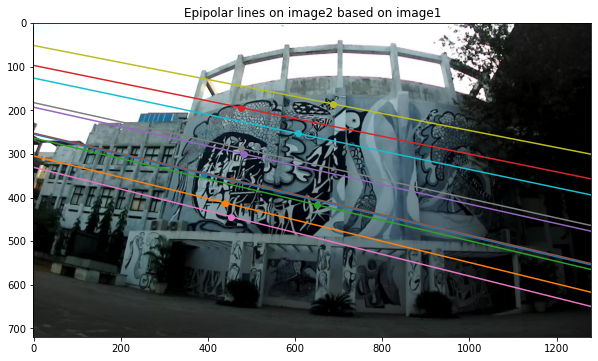

In [7]:
#Write code to plot epipolar lines on the images
plt.figure(figsize=(10,10))
for i in range(img_1.shape[0]):
    p1=img_2[i]
    p21=img_1[i]
    p1=p1.tolist()
    #print()
    p1=p1+[1]
    #p1=[p1]
    p1=np.transpose(p1)
    lin=np.matmul(F_mat.T,p1)
    lin=lin/lin[2]
    x=np.linspace(0,1300,5200)
    m=-lin[0]/lin[1]
    y=(m)*(x-p21[0])+p21[1]
    plt.plot(x,y)
    plt.scatter(p21[0],p21[1])
    plt.title('Epipolar lines on image1 based on image1')
img1=mpimg.imread('./q2/img1.jpg')
plt.imshow(img1)
plt.show()
plt.figure(figsize=(10,10))
for i in range(img_1.shape[0]):
    p1=img_1[i]
    p21=img_2[i]
    p1=p1.tolist()
    #print()
    p1=p1+[1]
    #p1=[p1]
    p1=np.transpose(p1)
    lin=np.matmul(F_mat,p1)
    lin=lin/lin[2]
    x=np.linspace(0,1300,5200)
    m=-lin[0]/lin[1]
    y=(m)*(x-p21[0])+p21[1]
    #line equation y=m(x-a)+c
    plt.plot(x,y)
    plt.scatter(p21[0],p21[1])
    plt.title('Epipolar lines on image2 based on image1')
img1=mpimg.imread('./q2/img2.jpg')
plt.imshow(img1)
plt.show()

Epipolar lines can be found by multipying Fundamental matrix (F_MAT) with image point coordinates. 

line in image1 is given as: line1 = $(FMAT) * imgPoints2$ 

line in image2 is given as: line2 = $(FMAT)^{T} * imgPoints1$ 

In [8]:
u,d,v=np.linalg.svd(F_mat,full_matrices=False)
print('eigen values :-',d)
v=v[2]
#print(v)
v/=v[2]
print('Epipole-1 is at pixel location:-',np.round(v[0:2]))
u,d,v=np.linalg.svd(F_mat.T,full_matrices=False)
print('eigen values :-',d)
v=v[2]
v/=v[2]
print('Epipole-1 is at pixel location:-',np.round(v[0:2]))

eigen values :- [1.00006000e+00 5.44295091e-05 2.46867046e-15]
Epipole-1 is at pixel location:- [2159. 1189.]
eigen values :- [1.00006000e+00 5.44295091e-05 2.46839192e-15]
Epipole-1 is at pixel location:- [-5132.  -949.]


#### Task 2
Report the location of the epipoles.

Epipole-1 is at pixel location:- [2159. 1189.]

Epipole-1 is at pixel location:- [-5132.  -949.]

for 1st image: epipolar is Fx=l1

here epipole belongs to null space of F for 1st image so the least eigen value considered as 0 which is the 3rd one and finding the eigen vector corresponding to the following eigen value only

for 1st image: epipolar is $F^T$x=l2

here epipole belongs to null space of $F^T$ for 2nd image so the least eigen value considered as 0 which is the 3rd one and finding the eigen vector corresponding to the following eigen value only

here the length of vector is 3 so divide it by the 3rd co-ordinate and make the 3rd co-ordinate 1 so that we are now taking the eigen vector having only 1st 2 co-ordiantes

here we get the decimal so used round to make it integer